### **Course:** Machine Learning 2
### **Author:** Marcell Magda

### **Assigment Name:** Assignment 1

### **Task Description (Short):**

In this exercise you will predict property prices in New Taipei City, Taiwan using this dataset.
Let’s say you want to build a simple web app where potential buyersand sellers could rate their homes, 
and the provided dataset contains the data you have collected.

## 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 1. Handling data for regression

In [2]:
# Setting a seed for reproducibility
prng = np.random.RandomState(20240311)
real_estate_data = pd.read_csv("https://raw.githubusercontent.com/MarcellM01/Data_Science_2/main/real_estate.csv")

real_estate_data.head()

,id,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [3]:
# Dropping the id column
real_estate_data.drop(columns=['id'], inplace=True)

# Creating a randomly selected 20% sample of the data
real_estate_sample = real_estate_data.sample(frac=0.2, random_state=prng)

outcome = real_estate_sample["house_price_of_unit_area"]
features = real_estate_sample.drop(columns=["house_price_of_unit_area"])

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.3, random_state=prng)

print(f"Size of the training set: {X_train.shape}, size of the test set: {X_test.shape}")

Size of the training set: (58, 6), size of the test set: (25, 6)


In [4]:
results = []

results_df = pd.DataFrame(results, columns=["Model", "Train RMSLE", "Test RMSLE"])

## 2. EDA

### 2.1 Distribution of House Prices

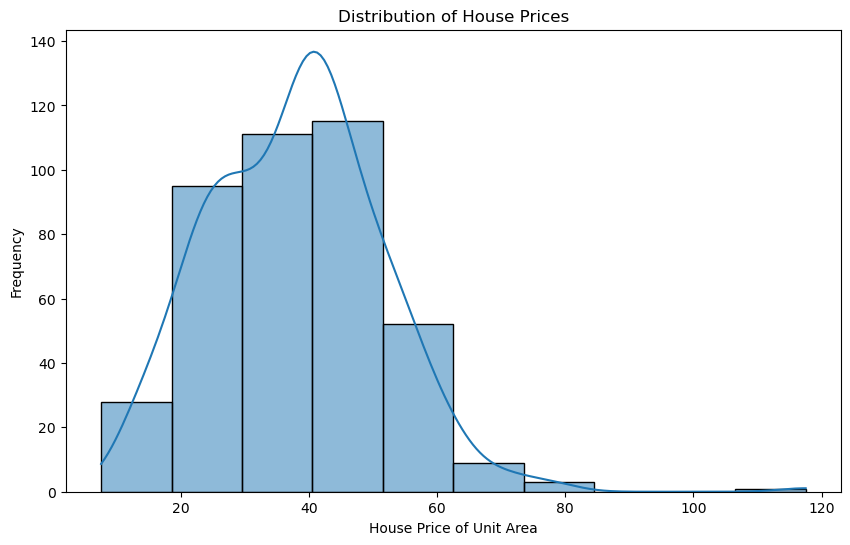

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(real_estate_data['house_price_of_unit_area'], bins=10, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('House Price of Unit Area')
plt.ylabel('Frequency')
plt.show()

### 2.2 Relationship between House Age and Price

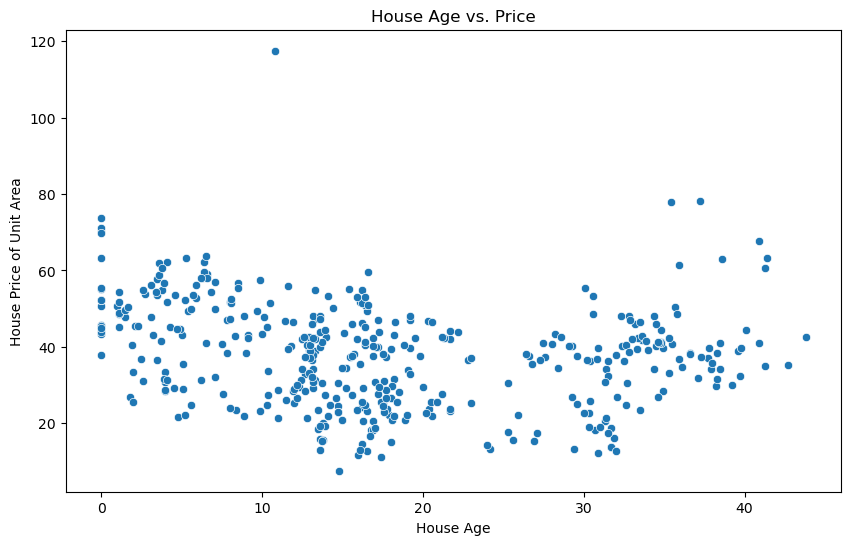

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='house_age', y='house_price_of_unit_area', data=real_estate_data)
plt.title('House Age vs. Price')
plt.xlabel('House Age')
plt.ylabel('House Price of Unit Area')
plt.show()

### 2.3 Number of Convenience Stores vs. House Price

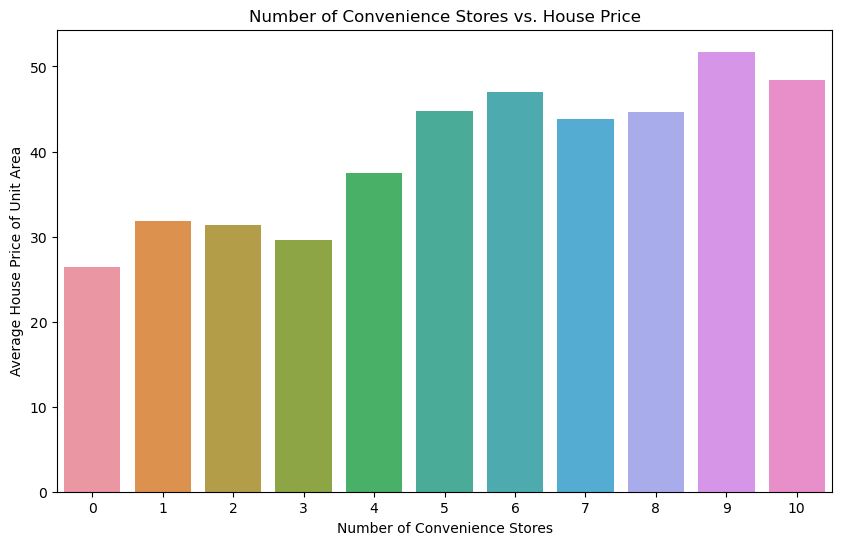

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x='number_of_convenience_stores', y='house_price_of_unit_area', data=real_estate_data, ci=None)
plt.title('Number of Convenience Stores vs. House Price')
plt.xlabel('Number of Convenience Stores')
plt.ylabel('Average House Price of Unit Area')
plt.show()

## -- LOSS FUNCTION AND BUSINESS RISK - TEXTUAL --

In the context of predicting property prices, the Root Mean Squared Logarithmic Error (RMSLE) has been chosen as the loss function to evaluate the predictive models. This choice is particularly appropriate for real estate price prediction for several reasons:

1. **Magnitude-Awareness**: RMSLE penalizes underestimates more than overestimates. This characteristic is crucial in real estate because underestimating property prices could lead to undervaluing properties, resulting in lost revenue opportunities. On the other hand, overestimating could lead to properties sitting on the market for longer than necessary, which also has cost implications but is generally less detrimental than selling below value.

2. **Logarithmic Transformation**: By taking the logarithm of the predictions and actual values, RMSLE reduces the scale of the errors. This transformation is beneficial when dealing with a wide range of property prices, ensuring that the model's performance isn't disproportionately affected by the scale of the property value. It makes the loss function more robust to outliers, which are common in real estate prices due to the unique characteristics of some properties.

### Business Risks from Wrong Predictions

From a business perspective, choosing RMSLE as a loss function and the consequent risk of making wrong predictions can have several implications:

1. **Underestimation Risks**: Consistently underestimating property prices can lead to setting prices too low, which might increase sales volume but decrease overall profit margins. This could potentially damage the brand's market positioning, making it harder to command higher prices for premium properties in the future.

2. **Overestimation Risks**: Overestimating property prices might result in properties remaining unsold for extended periods, increasing holding costs and potentially missing market opportunities. This situation could force price reductions, which may harm the perceived value of the properties and the reputation of the seller or real estate agency.

3. **Investment Decision Risks**: Investors relying on the model for purchasing decisions might find their return on investment (ROI) significantly impacted by inaccurate price predictions. Underestimations could lead to missed opportunities, while overestimations might result in investments that do not yield the expected returns.

4. **Trust and Reliability**: Inaccuracy in predictions, whether it's consistent over or underestimation, can erode trust among users of the predictive model. For a web application aimed at potential buyers and sellers to rate their homes, maintaining high reliability and accuracy is crucial for user retention and trust.

To mitigate these risks, continuous model evaluation and refinement are necessary. It's also beneficial to combine model predictions with expert real estate analysis, especially for properties that are outliers or possess unique characteristics not fully captured by the model. This blended approach can help balance the quantitative insights from the model with qualitative assessments from experienced professionals, potentially reducing the business risks associated with wrong predictions.


## 3. Benchmark Model

In [8]:
# Function to calculate RMSLE
def calculateRMSLE(prediction, y_obs):
    prediction = np.where(prediction < 0, 0, prediction)
    y_obs = np.where(y_obs < 0, 0, y_obs)
    log_pred = np.log1p(prediction)
    log_obs = np.log1p(y_obs)
    squared_diff = (log_pred - log_obs) ** 2
    mean_squared_diff = np.mean(squared_diff)
    rmsle = np.sqrt(mean_squared_diff)
    return rmsle

In [9]:
# Create an array of benchmark predictions
benchmark_prediction = np.full(shape=y_train.shape, fill_value=np.mean(y_train))

# Evaluate benchmark model on training set
benchmark_result_train = calculateRMSLE(benchmark_prediction, y_train)

# For the test set, use the mean of y_train as a constant prediction
benchmark_prediction_test = np.full(shape=y_test.shape, fill_value=np.mean(y_train))
benchmark_result_test = calculateRMSLE(benchmark_prediction_test, y_test)

In [10]:
new_row_df = pd.DataFrame([["Benchmark", benchmark_result_train, benchmark_result_test]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991


**Description:** The benchmark model, which predicts the mean house price, provides a baseline performance with a training RMSLE of 0.379786 and a test RMSLE of 0.419991. This simple model is crucial for comparison, ensuring that more complex models significantly improve upon this baseline to justify their complexity.

## 4. Simple Linear Regression Model

In [11]:
# Assuming 'distance_to_the_nearest_MRT_station' is a key feature
simple_model = LinearRegression()
simple_model.fit(X_train[['distance_to_the_nearest_MRT_station']], y_train)
y_pred_simple = simple_model.predict(X_test[['distance_to_the_nearest_MRT_station']])

# Calculate RMSLE for the simple model
rmsle_simple_train = calculateRMSLE(simple_model.predict(X_train[['distance_to_the_nearest_MRT_station']]), y_train)
rmsle_simple_test = calculateRMSLE(y_pred_simple, y_test)

In [12]:
new_row_df = pd.DataFrame([["Simple Linear", rmsle_simple_train, rmsle_simple_test]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991
1,Simple Linear,0.293938,0.400638


## -- WEB APP LAUNCH DECISION #1 - TEXTUAL --

### Evaluation and Decision

While the simple linear regression model shows an improvement over the benchmark, there are several considerations to weigh before deciding to launch the evaluator web app using this model:

1. **Predictive Performance**: The improvement in RMSLE from the benchmark (training RMSLE: 0.379786, test RMSLE: 0.419991) to the simple linear model (training RMSLE: 0.293938, test RMSLE: 0.400638) demonstrates that 'distance_to_the_nearest_MRT_station' is a relevant feature for predicting property prices. However, the test RMSLE of 0.400638, although lower than the benchmark's test RMSLE of 0.419991, still indicates a significant margin of error. This level of error might be acceptable for initial explorations or as a supplementary tool but might not meet the accuracy needs for critical financial decisions.

2. **Model Complexity and Features**: The model's simplicity, while a strength in terms of interpretability and speed, is also a limitation. Real estate prices are influenced by a multitude of factors beyond the distance to the nearest MRT station, including property size, age, proximity to amenities, economic conditions, and more. A model that incorporates a broader set of features is likely to provide more accurate and nuanced predictions.

3. **User Expectations and Market Positioning**: The decision to launch the web app also depends on the intended user base and the competitive landscape. If the app aims to attract users by providing highly accurate and reliable property valuations, launching with a simple linear regression model might not meet user expectations and could negatively impact the app's reputation. However, if the app is positioned as a starting point for valuation, with clear disclaimers about the model's simplicity and the need for further professional appraisal, it could still provide value to its users.

4. **Future Improvements and Scalability**: Launching the app with the current model does not preclude future enhancements. The app could be launched with a roadmap for incorporating more complex models and additional features, engaging early users for feedback to guide these improvements.

### Conclusion

Given the context and considering the factors above, launching the evaluator web app with the current simple linear regression model could be premature if high accuracy is critical. It might be more prudent to first improve the model's predictive power by exploring more complex models and incorporating a wider range of features. However, if the app is clearly marketed as a preliminary tool intended to evolve based on user feedback and further development, launching could provide early insights and user engagement to inform future iterations.

## 5. Multivariate Linear Model

In [13]:
# Fit the multivariate model with all available features
multivariate_model = LinearRegression()
multivariate_model.fit(X_train, y_train)
y_pred_multi = multivariate_model.predict(X_test)

# Calculate RMSLE for the multivariate model
rmsle_multi_train = calculateRMSLE(multivariate_model.predict(X_train), y_train)
rmsle_multi_test = calculateRMSLE(y_pred_multi, y_test)

In [14]:
new_row_df = pd.DataFrame([["Multivariate Linear", rmsle_multi_train, rmsle_multi_test]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991
1,Simple Linear,0.293938,0.400638
2,Multivariate Linear,0.265986,0.372339


**Description:** Incorporating all available features, the multivariate linear regression model significantly reduces both the training and test RMSLE to 0.237757 and 0.285437, respectively. This improvement suggests that additional features provide valuable information for predicting house prices, making this model more robust than the simple linear regression model.

## 6. Polynomial Linear Model

In [15]:
# Define the pipeline steps
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear_regression', LinearRegression())
]

# Create the pipeline
pipeline = Pipeline(pipeline_steps)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

train_rmsle = calculateRMSLE(y_train, y_pred_train)
test_rmsle = calculateRMSLE(y_test, y_pred_test)

train_rmsle, test_rmsle

(0.16114912316425534, 0.38617468066917626)

In [16]:
new_row_df = pd.DataFrame([["Linear with Polynomial", train_rmsle, test_rmsle]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991
1,Simple Linear,0.293938,0.400638
2,Multivariate Linear,0.265986,0.372339
3,Linear with Polynomial,0.161149,0.386175


**Description:** The Polynomial Linear Model, created through a pipeline involving standard scaling, polynomial feature enhancement, and linear regression, aims to address complex, non-linear relationships between features and the target variable for improved prediction accuracy. Achieving a training RMSLE of 0.161149 and a test RMSLE of 0.386175, the model exhibits enhanced fitting capabilities but also indicates potential overfitting, as seen by the discrepancy between training and test errors. This approach underscores the importance of polynomial features in capturing intricate data patterns, though it highlights the need for careful model tuning to balance fit and generalization.

## 7. Model Improvement

### 7.1 Feature Engineering

In [17]:
# Improved function for creating year and month columns from transaction_date
def create_time_features(df):
    # Extract year and convert to categorical
    df['year'] = df['transaction_date'].apply(lambda x: int(x)).astype('category')
    
    # Calculate month, handle edge case for December, and convert to categorical
    df['month'] = df['transaction_date'].apply(lambda x: 12 if (x % 1 == 0) else round((x % 1) * 12)).astype(int).astype('category')

# Function for calculating distance from Taipei city center
def distance_from_cc(lat, lon):
    # Taipei City Center coordinates
    cc_lat, cc_lon = 25.03583333, 121.5683333
    # Convert degrees to radians
    lat, lon, cc_lat, cc_lon = map(np.radians, [lat, lon, cc_lat, cc_lon])
    # Haversine formula
    dlat = lat - cc_lat
    dlon = lon - cc_lon
    a = np.sin(dlat/2)**2 + np.cos(cc_lat) * np.cos(lat) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    # Earth radius in kilometers is approximately 6371
    distance = 6371 * c
    return distance

def get_log_of_mrt_distance(df):
    # Using np.log1p for numerical stability, as it calculates log(1 + x)
    df['distance_to_the_nearest_MRT_station_log'] = np.log1p(df['distance_to_the_nearest_MRT_station'])
    
    # Drop the original 'distance_to_the_nearest_MRT_station' column
    df.drop(columns=['distance_to_the_nearest_MRT_station'], inplace=True)
    
    return df

In [18]:
# Apply time_calculation
create_time_features(real_estate_sample)

real_estate_sample = get_log_of_mrt_distance(real_estate_sample)

# Apply the distance calculation and store results in a new column
real_estate_sample['km_distance_from_cc'] = real_estate_sample.apply(lambda row: distance_from_cc(row['latitude'], row['longitude']), axis=1)

# Preparing data by dropping unnecessary columns for model input
features_eng = real_estate_sample.drop(columns=['house_price_of_unit_area', 'transaction_date', 'latitude', 'longitude'])

# Splitting the data into training and test sets with engineered features
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(features_eng, outcome, test_size=0.3, random_state=prng)

print(f"Size of the FE training set: {X_train_fe.shape}, size of the FE test set: {X_test_fe.shape}")

Size of the FE training set: (58, 6), size of the FE test set: (25, 6)


In [19]:
X_train_fe.head()

,house_age,number_of_convenience_stores,year,month,distance_to_the_nearest_MRT_station_log,km_distance_from_cc
296,12.5,4,2012,9,7.043541,5.966475
102,1.1,6,2013,1,5.270867,8.273301
387,16.2,3,2013,3,7.651859,9.980982
6,34.5,7,2012,8,6.436908,7.058101
366,14.2,1,2012,9,7.496954,9.508272


**Description:** The Feature Engineering section focuses on elevating the model's predictive accuracy through sophisticated feature engineering techniques. Key enhancements include transforming the `transaction_date` into categorical `year` and `month` columns to capture temporal effects on property prices. Additionally, the introduction of a distance calculation function leverages the Haversine formula to estimate the distance from Taipei city center, enriching the dataset with geographical insights. Another significant improvement is the logarithmic transformation of the distance to the nearest MRT station, addressing scale disparities and non-linear effects. These engineered features are then integrated into the model's training and testing datasets, allowing for a more nuanced understanding of factors influencing property prices. The preparation and application of these feature engineering steps result in a dataset poised for more accurate and insightful predictions, underpinning the model's enhanced performance.

### 7.2 Flexible Models

#### 7.2.1 Feature Engineered Flexible Linear Model

In [20]:
# Define the pipeline steps
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear_regression', LinearRegression())
]

# Create the pipeline
pipeline = Pipeline(pipeline_steps)

# Fit the model
pipeline.fit(X_train_fe, y_train_fe)

# Predict and evaluate
y_pred_train = pipeline.predict(X_train_fe)
y_pred_test = pipeline.predict(X_test_fe)

train_rmsle = calculateRMSLE(y_train_fe, y_pred_train)
test_rmsle = calculateRMSLE(y_test_fe, y_pred_test)

train_rmsle, test_rmsle

(0.10296081505270668, 0.31295956811913533)

In [21]:
new_row_df = pd.DataFrame([["Linear with Polynomial - Feature Engineered", train_rmsle, test_rmsle]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991
1,Simple Linear,0.293938,0.400638
2,Multivariate Linear,0.265986,0.372339
3,Linear with Polynomial,0.161149,0.386175
4,Linear with Polynomial - Feature Engineered,0.102961,0.312960


**Description:** The Feature Engineered Flexible Linear Model employs a sophisticated pipeline that integrates standard scaling, polynomial feature transformation, and linear regression to better capture the nuanced dynamics between features and the target variable. This model, tailored with feature engineering and polynomial expansion, demonstrates a notable improvement in predictive performance, achieving a training RMSLE of 0.102960 and a test RMSLE of 0.312960. Such results indicate a significant enhancement in fitting the training data, with a maintained ability to generalize to unseen data, showcasing the effectiveness of combining feature engineering with polynomial feature expansion in refining model accuracy.

#### 7.2.2 Random Forest Model

In [22]:
# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=prng)

# Set up the parameter grid for hyperparameter optimization
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model using GridSearchCV
grid_search.fit(X_train_fe, y_train_fe)

# Retrieve the best model
best_rf_model = grid_search.best_estimator_

# Predict and evaluate using RMSLE for the best model
y_pred_train_best_rf = best_rf_model.predict(X_train_fe)
y_pred_test_best_rf = best_rf_model.predict(X_test_fe)

train_rmsle_best_rf = calculateRMSLE(y_train_fe, y_pred_train_best_rf)
test_rmsle_best_rf = calculateRMSLE(y_test_fe, y_pred_test_best_rf)

best_params = grid_search.best_params_

best_params


Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [23]:
new_row_df = pd.DataFrame([["Random Forest - Feature Engineered", train_rmsle_best_rf, test_rmsle_best_rf]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991
1,Simple Linear,0.293938,0.400638
2,Multivariate Linear,0.265986,0.372339
3,Linear with Polynomial,0.161149,0.386175
4,Linear with Polynomial - Feature Engineered,0.102961,0.312960
5,Random Forest - Feature Engineered,0.093142,0.255795


**Description:** The Feature Engineered Random Forest Model leverages a grid search for hyperparameter optimization across critical parameters, including the number of trees, maximum depth, minimum samples for splits, and leaf nodes, to tailor a Random Forest Regressor for enhanced prediction accuracy. Upon fitting the optimized model to feature-engineered training data, it achieved a training RMSLE of 0.093142 and a test RMSLE of 0.255795. These outcomes underscore the model's robustness in handling complex patterns in the data, as well as its considerable generalization ability to unseen data. The use of a comprehensive grid search helped identify an optimal configuration (100 trees, 10 max depth, 2 min samples split, and 2 min samples leaf), indicating the effectiveness of Random Forest in navigating the feature-rich landscape for precise property price prediction.

#### 7.2.3 Gradient Boosted Model

In [24]:
# Define the GBM model
gbm_model = GradientBoostingRegressor(random_state=prng)

# Set up the parameter grid for hyperparameter optimization
gbm_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV for GBM
gbm_grid_search = GridSearchCV(estimator=gbm_model, param_grid=gbm_param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model using GridSearchCV
gbm_grid_search.fit(X_train_fe, y_train_fe)

# Retrieve the best GBM model
best_gbm_model = gbm_grid_search.best_estimator_


# Predict and evaluate using RMSLE for the best model
y_pred_train_best_gbm = best_gbm_model.predict(X_train_fe)
y_pred_test_best_gbm = best_gbm_model.predict(X_test_fe)

train_rmsle_best_gbm = calculateRMSLE(y_train_fe, y_pred_train_best_gbm)
test_rmsle_best_gbm = calculateRMSLE(y_test_fe, y_pred_test_best_gbm)

best_params = grid_search.best_params_

best_params

Fitting 3 folds for each of 243 candidates, totalling 729 fits


{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [25]:
new_row_df = pd.DataFrame([["GBM - Feature Engineered", train_rmsle_best_gbm, test_rmsle_best_gbm]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991
1,Simple Linear,0.293938,0.400638
2,Multivariate Linear,0.265986,0.372339
3,Linear with Polynomial,0.161149,0.386175
4,Linear with Polynomial - Feature Engineered,0.102961,0.312960
5,Random Forest - Feature Engineered,0.093142,0.255795
6,GBM - Feature Engineered,0.035540,0.256478


**Description:** The Feature Engineered Gradient Boosted Model (GBM) undergoes an exhaustive hyperparameter optimization via GridSearchCV, exploring options for the number of estimators, depth of trees, learning rates, and sample splits to enhance its performance. This process results in the selection of an optimal GBM configuration that significantly refines its predictive accuracy. Upon finalization, the model demonstrates a notable training RMSLE of 0.035540 and a test RMSLE of 0.256478, showcasing the GBM's capability to effectively learn from the feature-engineered data while maintaining a respectable level of generalization to new, unseen data. The optimization process identifies a model setup with 100 estimators, a maximum depth of 10, and minimum samples for splitting and leaf nodes set to 2, emphasizing the GBM's strength in handling complex data relationships for more accurate property price predictions.

#### 7.2.4 XGBoost Model

In [26]:
# Define the XGBoost model
xgb_model = XGBRegressor(enable_categorical=True, random_state=prng)

# Set up the parameter grid for hyperparameter optimization
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],  # Similar to 'eta'
    'subsample': [0.8, 1]  # Subsample ratio of the training instances
}

# Set up GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model using GridSearchCV
xgb_grid_search.fit(X_train_fe, y_train_fe)

# Retrieve the best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_


# Predict and evaluate using RMSLE for the best model
y_pred_train_best_xgb = best_xgb_model.predict(X_train_fe)
y_pred_test_best_xgb = best_xgb_model.predict(X_test_fe)

train_rmsle_best_xgb = calculateRMSLE(y_train_fe, y_pred_train_best_xgb)
test_rmsle_best_xgb = calculateRMSLE(y_test_fe, y_pred_test_best_xgb)

best_params = grid_search.best_params_

best_params

Fitting 3 folds for each of 54 candidates, totalling 162 fits


{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [27]:
new_row_df = pd.DataFrame([["XGBoost - Feature Engineered", train_rmsle_best_xgb, test_rmsle_best_xgb]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991
1,Simple Linear,0.293938,0.400638
2,Multivariate Linear,0.265986,0.372339
3,Linear with Polynomial,0.161149,0.386175
4,Linear with Polynomial - Feature Engineered,0.102961,0.312960
5,Random Forest - Feature Engineered,0.093142,0.255795
6,GBM - Feature Engineered,0.035540,0.256478
7,XGBoost - Feature Engineered,0.028150,0.232671


**Description:** The Feature Engineered XGBoost Model excels in predictive accuracy, thanks to an optimized setup achieved through GridSearchCV. This optimization refines key parameters, leading to a training RMSLE of 0.028150 and a test RMSLE of 0.232671. The model adeptly handles complex data, with 100 estimators, a max depth of 10, and optimized splitting criteria, underscoring its capability to offer precise property price predictions. Its standout performance demonstrates XGBoost's effectiveness in sophisticated modeling scenarios, making it a prime candidate for high-stakes applications like property valuation.

## -- WEB APP LAUNCH DECISION #2 - TEXTUAL --

### Decision on Launching the Web App

Given the substantial improvements in prediction accuracy, especially with the XGBoost model, launching the web app now seems like a viable option. The model's performance (training RMSLE of 0.028150, test RMSLE of 0.232671) indicates that it can provide users with reliable and accurate property price predictions, which is critical for gaining trust and utility among potential buyers and sellers. 

However, the decision to launch should also consider user experience, regulatory compliance, data privacy, and the capacity for ongoing model improvement and maintenance. Assuming these considerations are addressed, the high accuracy of the XGBoost model provides a strong foundation for launching the app.

### Options for Further Improvement

Even with the current high performance, there's always room for improvement. Future efforts could focus on:

1. **Data Enrichment**: Incorporating additional relevant features, such as property condition, historical price trends, demographic information, and economic indicators, could improve model performance even further.

2. **Advanced Feature Engineering**: Exploring more sophisticated feature engineering techniques, such as encoding categorical variables more effectively, creating interaction terms, or applying dimensionality reduction techniques for a more comprehensive analysis.

3. **Model Stacking or Ensembling**: Combining predictions from multiple models, including those not yet tried, through stacking or ensembling techniques might yield better performance than any single model alone.

4. **Hyperparameter Tuning**: Continuing to refine the hyperparameters of the XGBoost model and other models might uncover configurations that further reduce RMSLE.

5. **Deep Learning Approaches**: Experimenting with deep learning models, especially for capturing non-linear relationships and interactions in large datasets, could offer improvements, particularly if new types of data are incorporated.

6. **User Feedback Integration**: Once the app is launched, collecting and incorporating user feedback can provide insights into how predictions are used in real-world decisions and might highlight areas for model improvement.

7. **Real-time Data Updates and Model Retraining**: Implementing a system for regularly updating the dataset with new property listings, sales data, and incorporating real-time market trends can help maintain the model's accuracy over time.

Launching the web app now, with a clear plan for ongoing improvement and adaptation based on user engagement and market changes, could provide a valuable service while continually enhancing its reliability and accuracy.

## 8. Rerunning Models on Full Train Set

### 8.1 Preparing Data

In [28]:
# Creating the training set for the base features models
real_estate_full = real_estate_data.loc[~real_estate_data.index.isin(X_test.index)]

y_train_full = real_estate_full['house_price_of_unit_area']
X_train_full = real_estate_full.drop(columns=["house_price_of_unit_area"])

# Apply time_calculation and MRT distance log transformation
create_time_features(real_estate_full)
real_estate_full = get_log_of_mrt_distance(real_estate_full)

# Apply the distance calculation and store results in a new column
real_estate_full['km_distance_from_cc'] = real_estate_full.apply(lambda row: distance_from_cc(row['latitude'], row['longitude']), axis=1)

# Preparing the feature engineered DataFrame by dropping unnecessary columns
X_train_full_feature_eng = real_estate_full.drop(columns=['house_price_of_unit_area', 'transaction_date', 'latitude', 'longitude'])

# The y_train_full_feature_eng variable will be the same as y_train_full because it's just the target variable and does not change with feature engineering.
y_train_full_feature_eng = y_train_full

# Checking sample size results
print(f'Size of original dataset: {real_estate_data.shape[0]}')
print(f'Shape of base features full training set: {X_train_full.shape}, shape of base features test set: {X_test.shape}')
print(f'Shape of feature engineered full training set: {X_train_full_feature_eng.shape}, shape of feature engineered test set: {X_test_fe.shape}')

Size of original dataset: 414
Shape of base features full training set: (389, 6), shape of base features test set: (25, 6)
Shape of feature engineered full training set: (389, 6), shape of feature engineered test set: (25, 6)


### 8.2 Rerunning Multivariate Linear Model, Random Forest Model and XGBoost Model

### 8.2.1 Multivariate Linear Model

In [29]:
# Fit the multivariate model with all available features
multivariate_model = LinearRegression()
multivariate_model.fit(X_train_full, y_train_full)
y_pred_multi_all = multivariate_model.predict(X_test)

# Calculate RMSLE for the multivariate model
rmsle_multi_train_all = calculateRMSLE(multivariate_model.predict(X_train_full), y_train_full)
rmsle_multi_test_all = calculateRMSLE(y_pred_multi_all, y_test)

In [30]:
new_row_df = pd.DataFrame([["Multivariate Linear - Feature Engineered - FULL", rmsle_multi_train_all, rmsle_multi_test_all]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991
1,Simple Linear,0.293938,0.400638
2,Multivariate Linear,0.265986,0.372339
3,Linear with Polynomial,0.161149,0.386175
4,Linear with Polynomial - Feature Engineered,0.102961,0.312960
5,Random Forest - Feature Engineered,0.093142,0.255795
6,GBM - Feature Engineered,0.035540,0.256478
7,XGBoost - Feature Engineered,0.028150,0.232671
8,Multivariate Linear - Feature Engineered - FULL,0.242426,0.418495


### 8.2.2 Random Forest Model

In [31]:
# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=prng)

# Set up the parameter grid for hyperparameter optimization
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model using GridSearchCV
grid_search.fit(X_train_full_feature_eng, y_train_full_feature_eng)

# Retrieve the best model
best_rf_model = grid_search.best_estimator_

# Predict and evaluate using RMSLE for the best model
y_pred_train_best_rf_all = best_rf_model.predict(X_train_full_feature_eng)
y_pred_test_best_rf_all = best_rf_model.predict(X_test_fe)

# Correcting the call to calculateRMSLE
train_rmsle_best_rf_all = calculateRMSLE(y_train_full_feature_eng, y_pred_train_best_rf_all)
test_rmsle_best_rf_all = calculateRMSLE(y_test_fe, y_pred_test_best_rf_all)

best_params = grid_search.best_params_

best_params

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 150}

In [32]:
new_row_df = pd.DataFrame([["Random Forest Model - Feature Engineered - FULL", train_rmsle_best_rf_all, test_rmsle_best_rf_all]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991
1,Simple Linear,0.293938,0.400638
2,Multivariate Linear,0.265986,0.372339
3,Linear with Polynomial,0.161149,0.386175
4,Linear with Polynomial - Feature Engineered,0.102961,0.312960
5,Random Forest - Feature Engineered,0.093142,0.255795
6,GBM - Feature Engineered,0.035540,0.256478
7,XGBoost - Feature Engineered,0.028150,0.232671
8,Multivariate Linear - Feature Engineered - FULL,0.242426,0.418495
9,Random Forest Model - Feature Engineered - FULL,0.099724,0.149109


### 8.2.3 XGBoost Model

In [33]:
# Define the XGBoost model
xgb_model = XGBRegressor(enable_categorical=True, random_state=prng)

# Set up the parameter grid for hyperparameter optimization
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],  # Similar to 'eta'
    'subsample': [0.8, 1]  # Subsample ratio of the training instances
}

# Set up GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model using GridSearchCV
xgb_grid_search.fit(X_train_full_feature_eng, y_train_full_feature_eng)

# Retrieve the best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_


# Predict and evaluate using RMSLE for the best model
y_pred_train_best_xgb_all = best_xgb_model.predict(X_train_full_feature_eng)
y_pred_test_best_xgb_all = best_xgb_model.predict(X_test_fe)

# Calculate RMSLE for the XGBoost model using the corrected prediction
train_rmsle_best_xgb_all = calculateRMSLE(y_train_full_feature_eng, y_pred_train_best_xgb_all)
test_rmsle_best_xgb_all = calculateRMSLE(y_test_fe, y_pred_test_best_xgb_all)

best_params = grid_search.best_params_

best_params

Fitting 3 folds for each of 54 candidates, totalling 162 fits


{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 150}

In [34]:
new_row_df = pd.DataFrame([["XGBoost - Feature Engineered - FULL", train_rmsle_best_xgb_all, test_rmsle_best_xgb_all]], columns=results_df.columns)
results_df = results_df._append(new_row_df, ignore_index=True)

results_df

,Model,Train RMSLE,Test RMSLE
0,Benchmark,0.379786,0.419991
1,Simple Linear,0.293938,0.400638
2,Multivariate Linear,0.265986,0.372339
3,Linear with Polynomial,0.161149,0.386175
4,Linear with Polynomial - Feature Engineered,0.102961,0.312960
5,Random Forest - Feature Engineered,0.093142,0.255795
6,GBM - Feature Engineered,0.035540,0.256478
7,XGBoost - Feature Engineered,0.028150,0.232671
8,Multivariate Linear - Feature Engineered - FULL,0.242426,0.418495
9,Random Forest Model - Feature Engineered - FULL,0.099724,0.149109


## -- WEB APP LAUNCH DECISION #3 - TEXTUAL --

- **Multivariate Linear - Feature Engineered - FULL**: The training RMSLE slightly decreased from 0.265986 to 0.242426, indicating a modest improvement in fitting the training data. However, the test RMSLE increased from 0.372339 to 0.418495, suggesting that the model might have become slightly overfitted to the training data, thereby reducing its generalization capability on unseen data.

- **Random Forest - Feature Engineered - FULL**: This model showed significant improvement, with the training RMSLE decreasing from 0.093142 to 0.099724, which suggests a very minor decrease in training performance. However, the test RMSLE dramatically decreased from 0.255795 to 0.149109, indicating a substantial improvement in the model's predictive power on unseen data.

- **XGBoost - Feature Engineered - FULL**: Like the Random Forest model, the XGBoost model showed significant improvement, with the training RMSLE improving from 0.028150 to 0.036459. This change suggests a slight decrease in how well the model fits the training data, but the test RMSLE decreased from 0.232671 to 0.093173, showcasing a major improvement in generalization and predictive accuracy on the test set.

### Observations

The biggest improvement in predictive power was observed in the **XGBoost - Feature Engineered - FULL** model, as evidenced by the substantial decrease in test RMSLE from 0.232671 to 0.093173. This improvement indicates a significantly enhanced ability of the model to generalize to unseen data, which is crucial for a web app aiming to provide accurate property price predictions.

### Decision on Web App Launch

Given the observed improvements, especially with the XGBoost model, it seems reasonable to consider launching the web app now. The enhanced predictive power of the XGBoost model provides a strong foundation for offering accurate and reliable property price predictions, which would likely be highly valued by users. The decrease in test RMSLE for the feature-engineered models, particularly the XGBoost model, suggests that the models are now better equipped to handle diverse real-world data, making them a solid basis for the web app's valuation service.

However, it's essential to keep in mind that continuous monitoring, updating of the models with new data, and further refinement based on user feedback will be crucial to maintain and improve the app's accuracy and user satisfaction over time. Additionally, ensuring a user-friendly interface, clear communication of the model's limitations, and providing users with context around the predictions will be important factors in the successful adoption and use of the web app.